In [6]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)

Using TensorFlow backend.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/creditcardfraud/creditcard.csv


In [4]:
import pandas as pd
import numpy as np
credit = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [5]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Let us explore the data set

In [8]:
credit.shape

(284807, 31)

In [10]:
pd.value_counts(credit['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

This is a highly imbalanced data we have 492 frauds out of 284,807 transactions. The positive class (frauds) account for 0.172% of all transactions.

In [11]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


All the features are numeric. Further V1 - V28 are Principal Components

# Auto Encoders

In [12]:
normal_df = credit[credit.Class == 0] #save normal_df observations into a separate df
fraud_df = credit[credit.Class == 1] #do the same for frauds

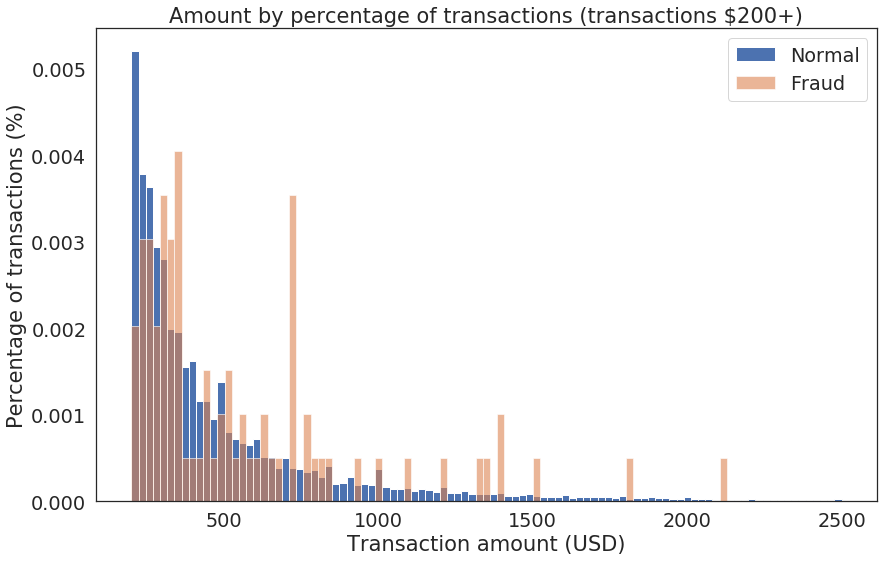

In [21]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");

Text(0, 0.5, 'Percentage of transactions (%)')

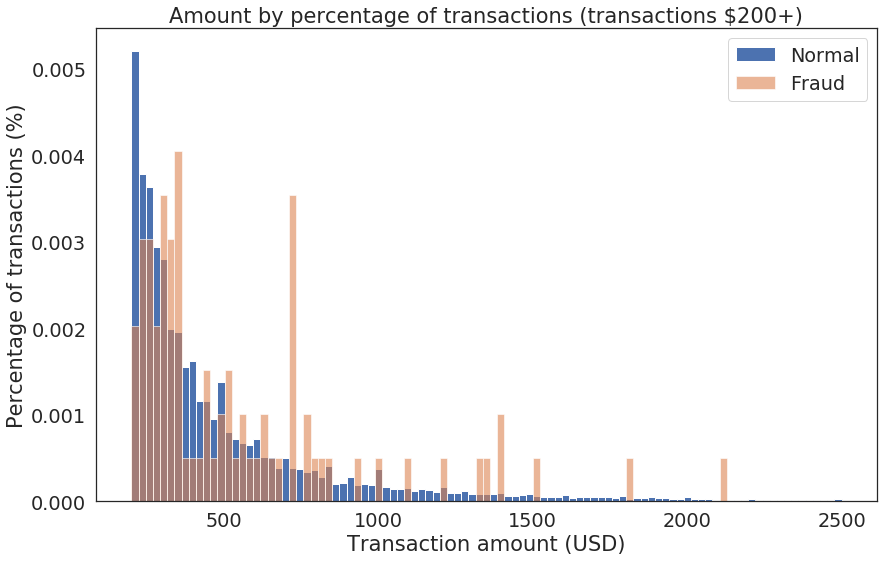

In [23]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")

# Data Preprocessing and Splitting

In [24]:
sc = StandardScaler()
df_norm = credit
df_norm['Time'] = sc.fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = sc.fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [36]:
train_x, test_x = train_test_split(df_norm, test_size=1/4, random_state=0)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [47]:
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

In [48]:
input_dim = train_x.shape[1]
encoding_dim = 14


input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [49]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 213233 samples, validate on 71202 samples
Epoch 1/100
213233/213233 [==============================] - 19s 89us/sample - loss: 0.8008 - accuracy: 0.5712 - val_loss: 0.7920 - val_accuracy: 0.6375
Epoch 2/100
213233/213233 [==============================] - 18s 86us/sample - loss: 0.7321 - accuracy: 0.6492 - val_loss: 0.7705 - val_accuracy: 0.6603
Epoch 3/100
213233/213233 [==============================] - 18s 86us/sample - loss: 0.7193 - accuracy: 0.6607 - val_loss: 0.7641 - val_accuracy: 0.6601
Epoch 4/100
213233/213233 [==============================] - 19s 89us/sample - loss: 0.7139 - accuracy: 0.6640 - val_loss: 0.7585 - val_accuracy: 0.6655
Epoch 5/100
213233/213233 [==============================] - 18s 86us/sample - loss: 0.7107 - accuracy: 0.6709 - val_loss: 0.7587 - val_accuracy: 0.6725
Epoch 6/100
213233/213233 [==============================] - 18s 86us/sample - loss: 0.7084 - accuracy: 0.6820 - val_loss: 0.7552 - val_accuracy: 0.6841
Epoch 7/100
213233/213233 [====

Epoch 54/100
213233/213233 [==============================] - 18s 83us/sample - loss: 0.6924 - accuracy: 0.7066 - val_loss: 0.7388 - val_accuracy: 0.7066
Epoch 55/100
213233/213233 [==============================] - 19s 89us/sample - loss: 0.6924 - accuracy: 0.7065 - val_loss: 0.7399 - val_accuracy: 0.7057
Epoch 56/100
213233/213233 [==============================] - 18s 87us/sample - loss: 0.6921 - accuracy: 0.7073 - val_loss: 0.7391 - val_accuracy: 0.7126
Epoch 57/100
213233/213233 [==============================] - 18s 84us/sample - loss: 0.6922 - accuracy: 0.7071 - val_loss: 0.7458 - val_accuracy: 0.6938
Epoch 58/100
213233/213233 [==============================] - 18s 84us/sample - loss: 0.6922 - accuracy: 0.7076 - val_loss: 0.7393 - val_accuracy: 0.7073
Epoch 59/100
213233/213233 [==============================] - 18s 86us/sample - loss: 0.6920 - accuracy: 0.7074 - val_loss: 0.7504 - val_accuracy: 0.6954
Epoch 60/100
213233/213233 [==============================] - 18s 83us/sampl

In [50]:
autoencoder = load_model('model.h5')

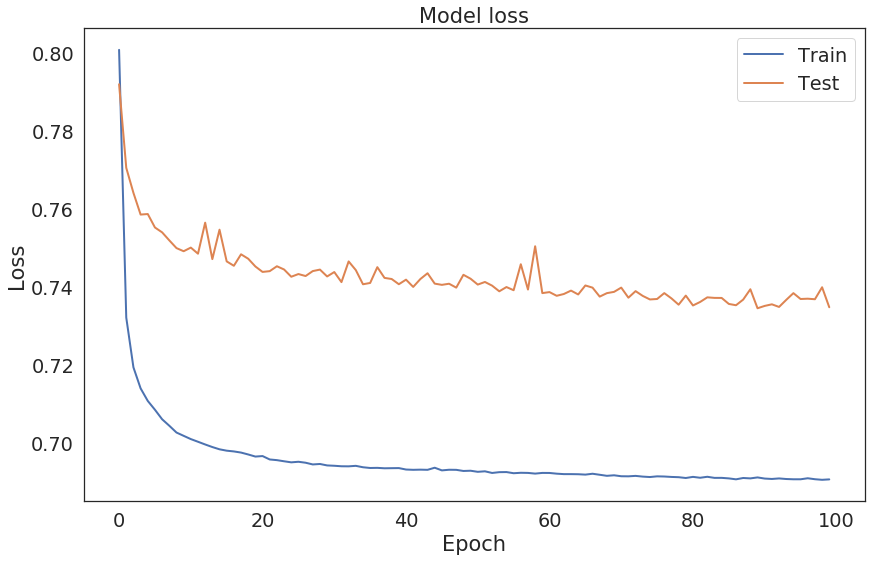

In [51]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [52]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
# error_df.describe()
error_df.True_class.value_counts()

0    71082
1      120
Name: True_class, dtype: int64

In [53]:
error_df.head()

,Reconstruction_error,True_class
183484,0.396591,0
255448,0.246366,0
244749,1.091656,0
63919,0.787083,0
11475,0.872069,0


Text(0.5, 0, 'False Positive Rate')

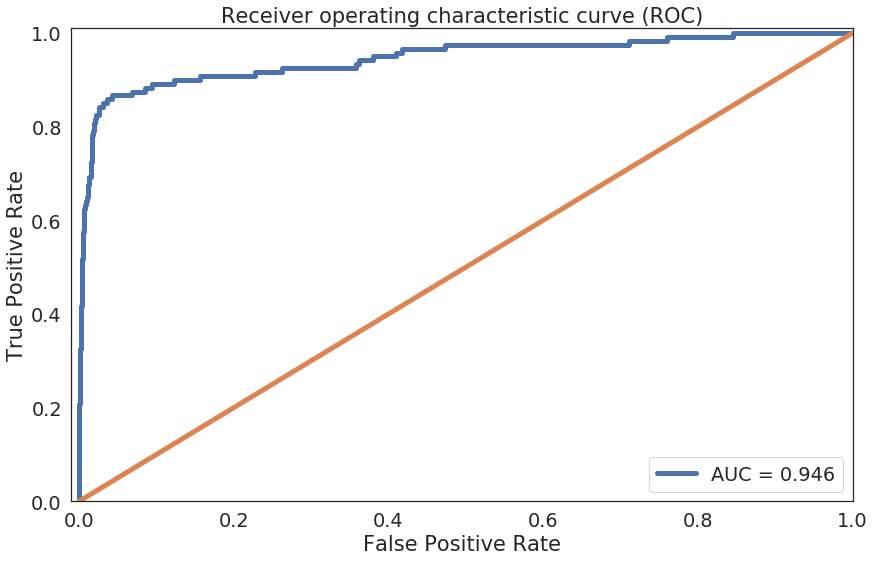

In [56]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

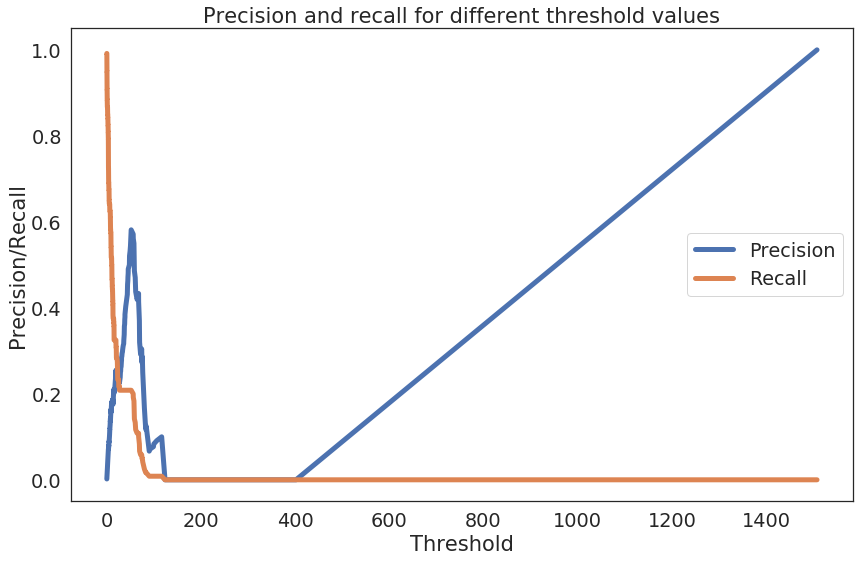

In [58]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

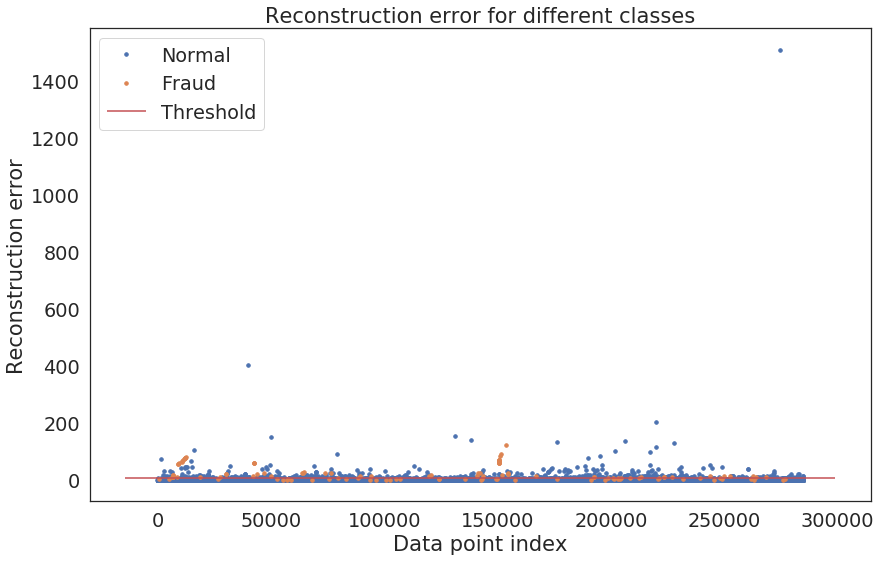

In [59]:
threshold_fixed = 4.9
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [60]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print(conf_matrix)

[[70260   822]
 [   40    80]]


In [62]:
from sklearn.metrics import classification_report
print(classification_report(error_df.True_class, pred_y))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71082
           1       0.09      0.67      0.16       120

    accuracy                           0.99     71202
   macro avg       0.54      0.83      0.58     71202
weighted avg       1.00      0.99      0.99     71202



Using XGBoost

In [63]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [69]:
xtrain, xtest, ytrain, ytest = train_test_split(credit.drop('Class', axis = 1), credit['Class'], test_size=1/4, random_state=0)

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import accuracy_score, f1_score
##  import required packages
##
import xgboost as xgb

'''
hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
hp.randint(label, upper) — Returns a random integer between the range [0, upper).
hp.uniform(label, low, high) — Returns a value uniformly between low and high.
hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer
hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.
'''

# defining the space for hyperparameter tuning
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }




def hyperparameter_tuning(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    evaluation = [( xtrain, ytrain), ( xtest, ytest)]
    
    clf.fit(xtrain, ytrain,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(xtest)
    fscore = f1_score(ytest, pred>0.5)
    print ("SCORE:", fscore)
    #change the metric if you like
    return {'loss': -fscore, 'status': STATUS_OK }


# run the hyper paramter tuning
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

SCORE:                                                 
0.0                                                    
SCORE:                                                               
0.6995073891625616                                                   
SCORE:                                                                              
0.7685185185185186                                                                  
SCORE:                                                                              
0.766355140186916                                                                   
SCORE:                                                                              
0.7428571428571429                                                                  
SCORE:                                                                              
0.7605633802816901                                                                  
SCORE:                                                              

SCORE:                                                                               
0.7834101382488479                                                                   
SCORE:                                                                               
0.7834101382488479                                                                 
SCORE:                                                                             
0.6965174129353233                                                                 
SCORE:                                                                             
0.70935960591133                                                                     
SCORE:                                                                               
0.7641509433962266                                                                   
SCORE:                                                                               
0.7834101382488479                                            

0.7699530516431925                                                                   
SCORE:                                                                               
0.7757009345794391                                                                   
SCORE:                                                                               
0.7488151658767772                                                                   
SCORE:                                                                               
0.70935960591133                                                                     
SCORE:                                                                               
0.70935960591133                                                                     
100%|██████████| 100/100 [1:55:45<00:00, 69.46s/trial, best loss: -0.7889908256880733]
{'colsample_bytree': 0.781669156785316, 'gamma': 1.709543777297502, 'max_depth': 10.0, 'min_child_weight': 5.0, 'reg_alpha': 42.0, 'reg_lam

In [70]:
    clf = xgb.XGBClassifier(n_estimators =180, max_depth = int(best['max_depth']), gamma = best['gamma'],
                         reg_alpha = best['reg_alpha'],min_child_weight=best['min_child_weight'],
                         colsample_bytree=best['colsample_bytree'])
    clf.fit(xtrain,ytrain)
    ypred = clf.predict(xtest)
    

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,ypred)

array([[71070,    12],
       [   34,    86]])

In [76]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.88      0.72      0.79       120

    accuracy                           1.00     71202
   macro avg       0.94      0.86      0.89     71202
weighted avg       1.00      1.00      1.00     71202

